In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import os
import random

#  Definition of the Segmentation Model

## Utilities
### Taken from https://github.com/camara94/computer_vision_lab/blob/main/C3_W3_Lab_2_OxfordPets_UNet.ipynb and adapted to binary classification

In [2]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [3]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [4]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax' if output_channels > 1 else 'sigmoid')(c9)

  return outputs

## Model

In [5]:
OUTPUT_CHANNELS = 1

def unet(shape=(128, 128,3,)):
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=shape)

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


image_size = (256, 256)
model = unet((image_size[0], image_size[1], 3,))

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [6]:
# from tensorflow.keras.utils import plot_model

# # Plot the model architecture
# plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


# Dataset preparation

In [7]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(self.image_dir)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = self.__data_generation(batch_filenames)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_filenames):
        images = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)
        for i, filename in enumerate(batch_filenames):
            img_path = os.path.join(self.image_dir, filename)
            img = Image.open(img_path).resize(self.image_size)
            img = np.array(img) / 255.0
            images[i] = img

            mask_filename = 'mask_' + '_'.join(filename.split('_')[1:])
            if ' ' in mask_filename:
                fn_1 = mask_filename.split(' ')[0]
                fn_2 = mask_filename.split('.')[-1]
                mask_filename = fn_1 + '.' + fn_2

            mask_path = os.path.join(self.mask_dir, mask_filename)
            mask = Image.open(mask_path).resize(self.image_size)
            mask = np.array(mask)[:, :, 0]/255.0
            masks[i] = np.expand_dims(mask, axis=-1)
        return images, masks


train:  (32, 256, 256, 3) (32, 256, 256, 1)


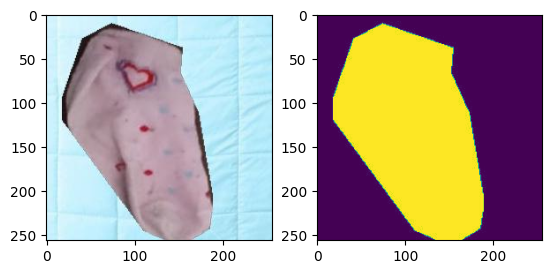

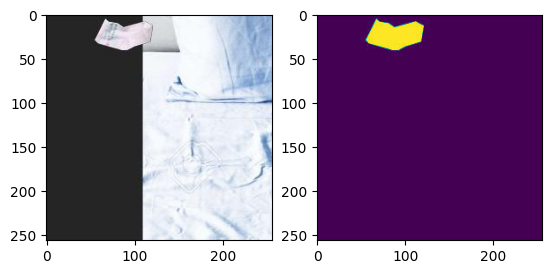

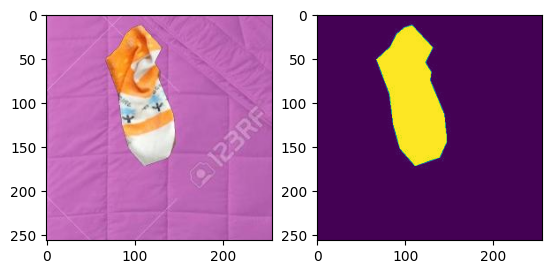

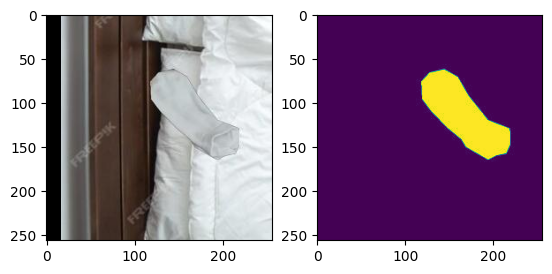

test:  (32, 256, 256, 3) (32, 256, 256, 1)


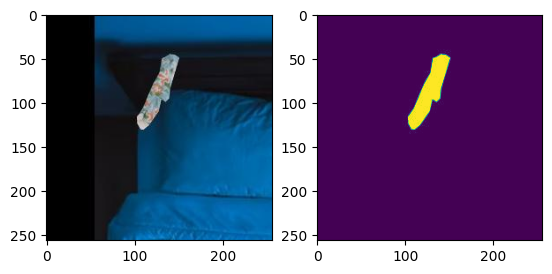

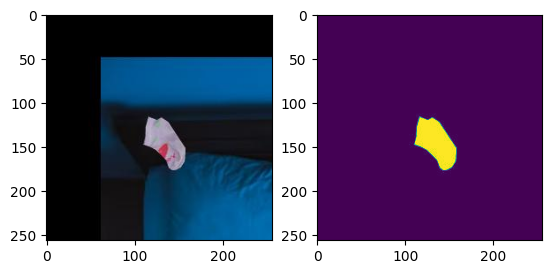

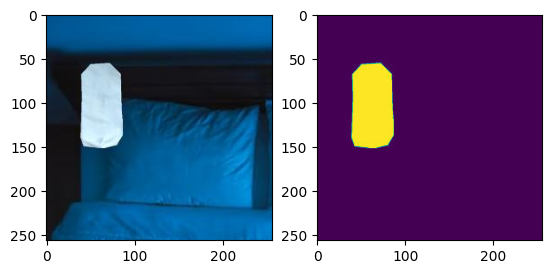

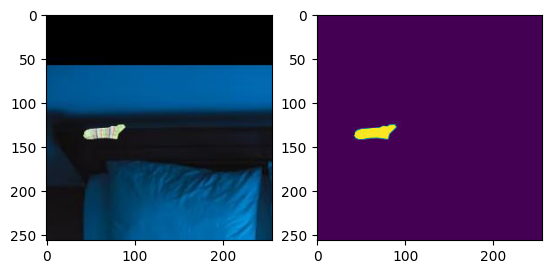

In [8]:
# Split filenames into train and test sets
directory = r"C:\TRABAJO\Apps\socks_matcher\pasted"

# from google.colab import drive
# drive.mount('/content/drive')
# directory = r'/content/drive/MyDrive/Colab Notebooks/pasted'


n_images = 5
image_filenames = os.listdir(os.path.join(directory, "images"))
train_filenames, test_filenames = train_test_split(image_filenames, test_size=0.2, shuffle=True)

# Create Data Generators
train_generator = DataGenerator(os.path.join(directory, "images"),
                                os.path.join(directory, "masks"),
                                batch_size=32,
                                image_size=image_size,
                                shuffle=True)
test_generator = DataGenerator(os.path.join(directory, "images"),
                               os.path.join(directory, "masks"),
                               batch_size=32,
                               image_size=image_size,
                               shuffle=False)

# Extract images and masks from the generators
images_train, masks_train = next(iter(train_generator))  # Get a batch of data
images_test, masks_test = next(iter(test_generator))    # Get a batch of data


print('train: ', images_train.shape, masks_train.shape)
i = 0
for image, mask in zip(images_train, masks_train):
    i += 1
    if i >= n_images:
        break
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()

print('test: ', images_test.shape, masks_test.shape)
i = 0
for image, mask in zip(images_test, masks_test):
    i += 1
    if i >= n_images:
        break
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(mask)
    plt.show()


# Training

In [9]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# # Print dtype of each layer
# for layer in model.layers:
#     print(f'Layer {layer.name} dtype: {layer.dtype}')

# # Print dtype of each weight
# for layer in model.layers:
#     for weight in layer.weights:
#         print(f'Weight {weight.name} dtype: {weight.dtype}')

In [11]:
# # configure the training parameters and train the model
# BATCH_SIZE = 32
# EPOCHS = 10
# VALIDATION_STEPS = 5

# # this will take around 20 minutes to run
# model_history = model.fit(train_generator,
#                           epochs=EPOCHS,
#                           validation_data=test_generator,
#                           validation_steps=VALIDATION_STEPS)

In [12]:
if image_size == (128,128):
    model.load_weights('unet_model_colab_full_128.h5')

if image_size == (256,256):
    model.load_weights('unet_model_colab_full.h5')



In [13]:
# # Evaluate the model i the first batch
# loss, accuracy = model.evaluate(images_train, masks_train)
# print(f"Training loss: {loss}")
# print(f"Training accuracy: {accuracy}")

# loss, accuracy = model.evaluate(images_test, masks_test)
# print(f"Test loss: {loss}")
# print(f"Test accuracy: {accuracy}")

# Some tests!


******
test:  (32, 256, 256, 3) (32, 256, 256, 1)
1/1 [==============================] - 1s 1s/step


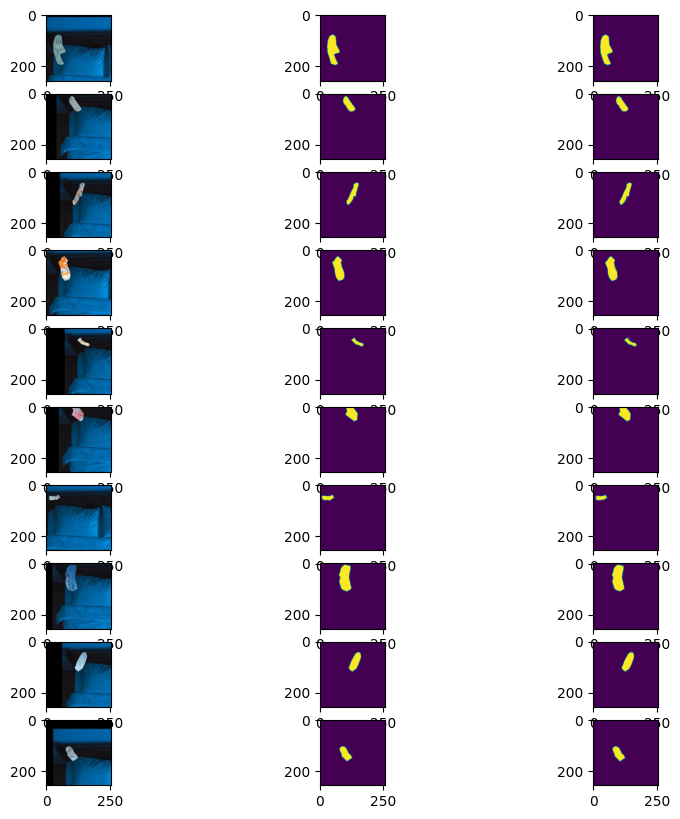

In [14]:
n_images = 10
th = 0.5

# print('train: ', images_train.shape, masks_train.shape)
# i = 0
# fig, ax = plt.subplots(n_images, 3, figsize=(10,10))

# # Assuming images_test and masks_test are lists or arrays
# indices = list(range(len(images_train)))
# random.shuffle(indices)
# for i_ax, i in enumerate(indices):
#     image = images_train[i, :, :, :]
#     mask = masks_train[i, :, :, :]    
#     if i_ax >= n_images:
#         break
#     ax[i_ax,0].imshow(image)
#     ax[i_ax,1].imshow(mask)
#     ax[i_ax,2].imshow(model.predict(image.reshape((1, )+image.shape))[0])
#     i += 1
# plt.show()

print('\n******\ntest: ', images_test.shape, masks_test.shape)
i = 0
fig, ax = plt.subplots(n_images, 3, figsize=(10,10))
indices = list(range(len(images_test)))
random.shuffle(indices)
for i_ax, i in enumerate(indices):
    image = images_test[i, :, :, :]
    mask = masks_test[i, :, :, :]  
    if i_ax >= n_images:
        break
    ax[i_ax,0].imshow(image)
    ax[i_ax,1].imshow(mask)
    ax[i_ax,2].imshow(model.predict(image.reshape((1, )+image.shape))[0])
    i += 1
plt.show()



# Test in production

In [15]:
def sliding_window_segmentation(image, model, patch_size=128, stride=128):
    h, w, c = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
    
    segmented_image = np.zeros((h + pad_h, w + pad_w, 1))
    weight_map = np.zeros((h + pad_h, w + pad_w, 1))
    
    for i in range(0, padded_image.shape[0] - patch_size + 1, stride):
        for j in range(0, padded_image.shape[1] - patch_size + 1, stride):
            patch = padded_image[i:i+patch_size, j:j+patch_size, :]
            prediction = model.predict(patch.reshape((1, )+patch.shape))[0]
            
            segmented_image[i:i+patch_size, j:j+patch_size, :] += prediction
            weight_map[i:i+patch_size, j:j+patch_size, :] += 1
    
    segmented_image /= weight_map
    segmented_image = 1-segmented_image[:h, :w, :]  # Crop to original size
    return np.array(255*segmented_image, dtype='uint8')


1/1 [==============================] - 1s 1s/step


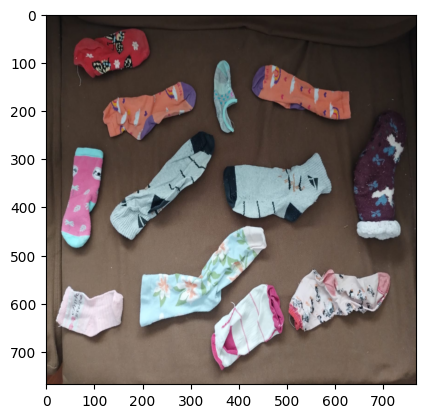

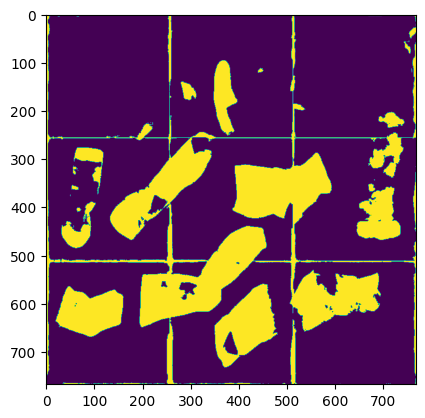

In [27]:
# Example usage
proc_size = 3*np.array(image_size)
img_path = r"C:\TRABAJO\Apps\socks_matcher\socks2.jpeg"
large_image = np.array(Image.open(img_path).resize(proc_size))

segmented_large_image = sliding_window_segmentation(large_image, model, patch_size=image_size[0], stride=image_size[0])
plt.figure()
plt.imshow(large_image)
plt.figure()
plt.imshow(segmented_large_image)
plt.show()

## Morphological filters

In [28]:
import cv2 as cv2


def convex_hull_mask(labels):
    """
    Creates a mask where each connected component is replaced by its convex hull.

    Args:
        image: The original binary image.
        labels: The labeled image where each connected component has a unique integer label.

    Returns:
        A mask image where each connected component is replaced by its convex hull.
    """
    mask = np.zeros_like(labels, dtype=np.uint8)
    for label in np.unique(labels)[1:]:  # Skip background (label 0)
        # Create a binary mask for the current label
        component_mask = (labels == label).astype(np.uint8)
        
        # Find contours for the current label
        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Check if any contours are found
        if contours:
            # Get the convex hull for the first contour
            hull = cv2.convexHull(contours[0])
            
            # Draw the convex hull on the mask
            print(label)
            cv2.drawContours(mask, [hull], 0, int(label), -1)  # Fill the entire hull

    return mask

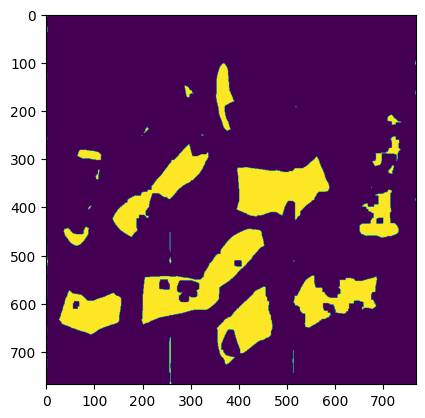

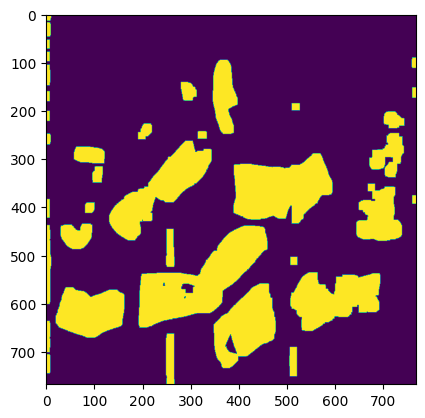

1
2
3
4
5
6
7
8


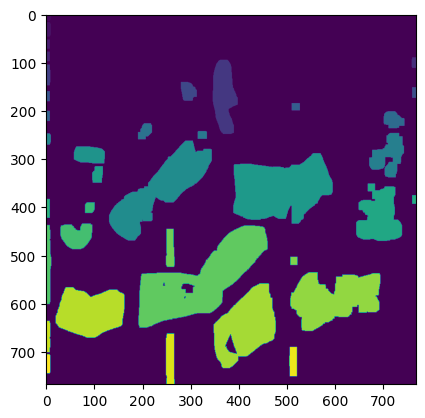

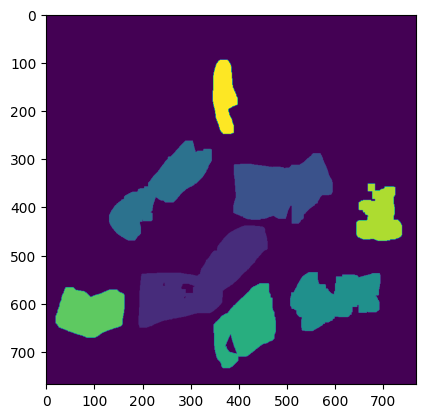

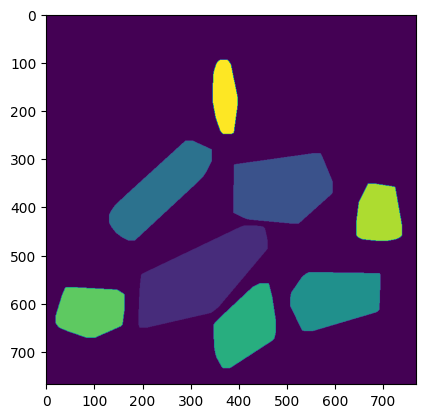

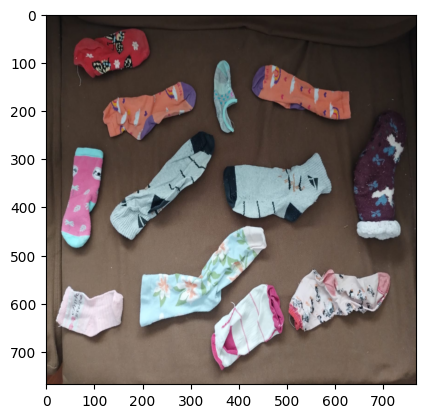

In [29]:
# binary
binary_segmented_large_image = np.array(np.where(segmented_large_image > 128, 255, 0), np.uint8)

# erosion
eroded_segmented_large_image = cv2.erode(binary_segmented_large_image, np.ones((10, 10), np.uint8))
plt.figure()
plt.imshow(eroded_segmented_large_image)
plt.show()

dilated_segmented_large_image = cv2.dilate(eroded_segmented_large_image, np.ones((15, 15), np.uint8))
plt.figure()
plt.imshow(dilated_segmented_large_image)
plt.show()

# connected components
th_area = 0.2
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_segmented_large_image)
sort_ind = np.argsort(stats[:, cv2.CC_STAT_AREA])[::-1]
stats, centroids = stats[sort_ind, :], centroids[sort_ind, :]
# print(retval, stats, centroids)

new_labels = np.zeros_like(labels)
largest = th_area*stats[1, cv2.CC_STAT_AREA]
current_label = 0
for i in sort_ind:
  # Assign new label (current_label) to pixels with label value (i+1) from original labels
  new_labels[labels == i] = current_label
  current_label += 1
  if stats[current_label, cv2.CC_STAT_AREA] < largest:
    break
stats, centroids = stats[:current_label, :], centroids[:current_label, :]
retval = current_label

convex_labels = convex_hull_mask(new_labels)


# print(retval, stats, centroids)


plt.figure()
plt.imshow(labels)
plt.show()


plt.figure()
plt.imshow(new_labels)
plt.show()

plt.figure()
plt.imshow(convex_labels)
plt.show()

plt.figure()
plt.imshow(large_image)
plt.show()

# Using color segmentation 

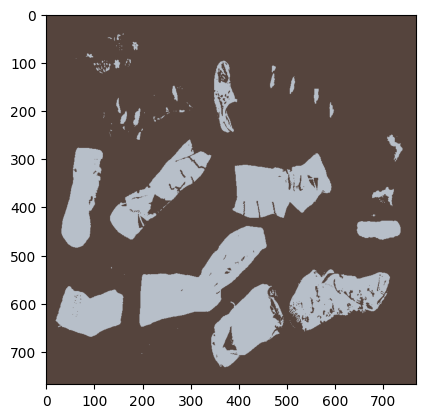

In [30]:
def quantize_colors(image, k):
    """
    Quantizes the colors in an image to k colors using k-means clustering.

    Args:
        image: The input image.
        k: The number of colors to quantize to.

    Returns:
        The quantized image.
    """
    # Convert image to float32
    data = np.float32(image).reshape((-1, 3))
    
    # Define criteria and apply k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert centers to uint8 and reshape labels to match the original image shape
    centers = np.uint8(centers)
    quantized_image = centers[labels.flatten()]
    quantized_image = quantized_image.reshape(image.shape)
    
    return quantized_image

# Example usage
quantized_image = quantize_colors(large_image, k=2)
plt.figure()
plt.imshow(quantized_image)

# Using contours

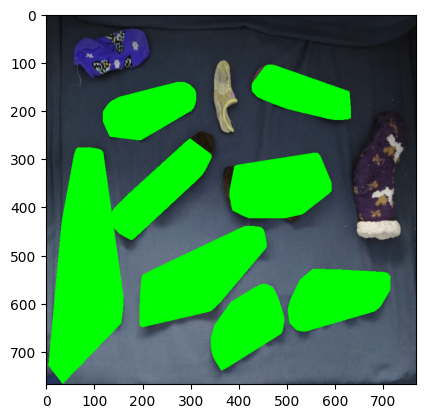

In [31]:
# Step 1: Load the image
image = large_image

# Step 2: Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Apply a threshold or edge detection
edges = cv2.Canny(gray, 100, 200)

# Step 4: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Form convex hulls
convex_hulls = [cv2.convexHull(contour) for contour in contours]

# Create an empty mask to draw filled convex hulls
hull_mask = np.zeros_like(gray)

# Fill convex hulls on the mask
for hull in convex_hulls:
    cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

# Apply dilation and erosion
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(hull_mask, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

# Find convex hulls on each contour after dilation and erosion
contours_after_morph, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
convex_hulls_after_morph = [cv2.convexHull(contour) for contour in contours_after_morph]

# Create an empty mask to draw filled convex hulls after morphology operations
hull_mask_after_morph = np.zeros_like(gray)

# Fill convex hulls on the mask after morphology operations
for hull in convex_hulls_after_morph:
    cv2.drawContours(hull_mask_after_morph, [hull], -1, 255, thickness=cv2.FILLED)

# Step 6: Find connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(hull_mask_after_morph)

# Step 7: Retain components with larger area
sorted_areas = np.sort(stats[:, cv2.CC_STAT_AREA])

min_area = 0.1 * sorted_areas[-2]  # Set the minimum area threshold
filtered_mask = np.zeros_like(gray)

for i in range(1, num_labels):  # Start from 1 to skip the background
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_mask[labels == i] = 255

# Optional: Draw the filtered components on the original image for visualization
output_image = image.copy()
output_image[filtered_mask == 255] = [0, 255, 0]  # Draw in green

# Display the result
plt.figure()
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.show()